# Introduction

- In this notebook, we use the initially cleaned eviction data and turn it into geodataframe. From cleaning_eviction notebook, we have known the evictions during and outside of covid behave drastically differently, therefore, in this notebook, we break the initial cleaned_eviction df into 2 parts: covid and pre-post covid.

- In order to analyze the building per year eviction data, we aggregate and merge based on bbl and create the new column "average_year_eviction_countr", representing avegrae evictions per year per building. For each dataframe, we visualize the trends over the years in aggregated data and per building per year data, with stats summary. We also visualize the eviction distributions in nyc with plotly and folium on maps. To make the visuals more clear, we create different maps with different thresholds.  

- Finally, we find the buildings with the most evictions (> 10 or >5) on each period. We will use these bbl and merge them with BBL.csv to find the exact buildings and locate the landlords. Further analysis will continue in the same series notebooks until clustering analysis and getting to know the data is done.

- All charts, summaries, maps can be found in images folder.

In [35]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy esda splot

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime as dt
import scipy

from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# visualization
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
import folium
from folium.plugins import HeatMap
from folium import Marker
from folium.plugins import MarkerCluster
import plotly.express as px
import plotly.io as pio

# spatial statistics
from esda.moran import Moran
from esda.getisord import G_Local
from libpysal.weights import Queen, Rook

# system and utility
import warnings
import os
import io
from IPython.display import IFrame
from google.colab import files

from libpysal.weights import Queen, Rook
from esda.moran import Moran
import matplotlib.pyplot as plt
from splot.esda import moran_scatterplot

# suppress warnings
warnings.filterwarnings('ignore')

# inline
%matplotlib inline

# Part 1 Get the Eviction data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data source:
file_path = '/content/drive/My Drive/X999/evictions_df_cleaned.csv'

In [ ]:
evictions_df_raw = pd.read_csv(file_path)

In [44]:
evictions_df = evictions_df_raw.copy()

In [45]:
evictions_df.head(2)

court_index_number  docket_number     eviction_address  \
0           34859/16          53416  3476 SEYMOUR AVENUE   
1          B57808/16          74242   1426 BRYANT AVENUE   

  eviction_apartment_number executed_date borough  eviction_postcode  \
0                       3-B    2017-01-03   BRONX              10469   
1        10 AKA 2ND FL UNIT    2017-01-03   BRONX              10459   

          ejectment eviction/legal_possession   latitude  longitude  \
0  Not an Ejectment                Possession  40.877620 -73.849806   
1  Not an Ejectment                Possession  40.830691 -73.888555   

   community_board  council_district  census_tract        bin           bbl  \
0             12.0              12.0         386.0  2117041.0  2.047200e+09   
1              3.0              17.0         123.0  2099901.0  2.029990e+09   

                               nta  
0  Eastchester-Edenwald-Baychester  
1                Crotona Park East

In [46]:
evictions_df.columns, \
evictions_df.shape

(Index(['court_index_number', 'docket_number', 'eviction_address',
        'eviction_apartment_number', 'executed_date', 'borough',
        'eviction_postcode', 'ejectment', 'eviction/legal_possession',
        'latitude', 'longitude', 'community_board', 'council_district',
        'census_tract', 'bin', 'bbl', 'nta'],
       dtype='object'),
 (80420, 17))

In [47]:
evictions_df.executed_date = pd.to_datetime(evictions_df.executed_date)

In [48]:
evictions_df.executed_date.min(), evictions_df.executed_date.max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2024-12-30 00:00:00'))

# Part 2 Get to know the GeoDataFrame

#### To properly understand the geo features and find hot spots in this evcition datasets, we need to utilize the GeoDataFrame to see if there is any interesting patterns that could be attributed to Societal trends/Predatory landlord bahaviors/corporate landlord behaviors

In [49]:
# first, we create a GeoDataFrame
evictions_gdf = gpd.GeoDataFrame(
    evictions_df,
    geometry=gpd.points_from_xy(evictions_df['longitude'], evictions_df['latitude']))

In [50]:
evictions_gdf.head(2)

court_index_number  docket_number     eviction_address  \
0           34859/16          53416  3476 SEYMOUR AVENUE   
1          B57808/16          74242   1426 BRYANT AVENUE   

  eviction_apartment_number executed_date borough  eviction_postcode  \
0                       3-B    2017-01-03   BRONX              10469   
1        10 AKA 2ND FL UNIT    2017-01-03   BRONX              10459   

          ejectment eviction/legal_possession   latitude  longitude  \
0  Not an Ejectment                Possession  40.877620 -73.849806   
1  Not an Ejectment                Possession  40.830691 -73.888555   

   community_board  council_district  census_tract        bin           bbl  \
0             12.0              12.0         386.0  2117041.0  2.047200e+09   
1              3.0              17.0         123.0  2099901.0  2.029990e+09   

                               nta                    geometry  
0  Eastchester-Edenwald-Baychester  POINT (-73.84981 40.87762)  
1                Crotona Park East  POINT (-73.88856 40.83069)

In [51]:
evictions_cleaned = evictions_gdf.dropna(subset=['latitude', 'longitude'])
evictions_cleaned = evictions_cleaned.reset_index(drop=True)

In [52]:
evictions_cleaned.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry'],
      dtype='object')

## Part 2.1: Aggregation to find eviction counts (with BBL)

#### Aggregate by BBL:

BBL appears to be the most sensible basic unit here, as other ones: apartment unit, neighborhood, zipcode, and borough would either be too small (non-representable) or too large to understand landlord behaviors.

In [53]:
# groupby
evictions_by_bbl = evictions_cleaned.groupby('bbl').size().reset_index(name='eviction_count')
# merge
evictions_cleaned = evictions_cleaned.merge(evictions_by_bbl, on='bbl', how='left')

In [54]:
evictions_cleaned.columns
# eviction_count added

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count'],
      dtype='object')

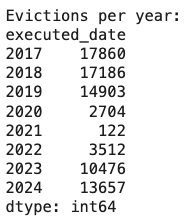

In [37]:
# the reason why we need to classify the years as pre covid and pre/post covid.
# because landlord behaviors tell very different stories
# pre and after covid: 2017-2019, 2023 - 2024
# covid: 2020-2022
from google.colab import files
from IPython.display import Image
# uploaded = files.upload()
Image(filename='evictions_per_year.png')

In [74]:
evictions_cleaned['year'] = evictions_cleaned['executed_date'].dt.year
pre_post_covid_years = [2017, 2018, 2019, 2023, 2024]
covid_years = [2020, 2021, 2022]

In [75]:
evictions_pre_post_covid = evictions_cleaned[evictions_cleaned['year'].isin(pre_post_covid_years)].copy()
evictions_covid = evictions_cleaned[evictions_cleaned['year'].isin(covid_years)].copy()

In [77]:
len(evictions_pre_post_covid), \
len(evictions_covid)

(74082, 6338)

In [78]:
pre_post_covid_counts = evictions_pre_post_covid.groupby(['bbl', 'year']).size().reset_index(name='eviction_count')
pre_post_covid_avg = pre_post_covid_counts.groupby('bbl')['eviction_count'].mean().reset_index(name='average_year_eviction_count')

In [79]:
covid_period_counts = evictions_covid.groupby(['bbl', 'year']).size().reset_index(name='eviction_count')
covid_period_avg = covid_period_counts.groupby('bbl')['eviction_count'].mean().reset_index(name='average_year_eviction_count')

In [80]:
# merge
evictions_pre_post_covid = evictions_pre_post_covid.merge(pre_post_covid_avg, on='bbl', how='left')
evictions_covid = evictions_covid.merge(covid_period_avg, on='bbl', how='left')

Now, we have 2 dataframes, one is post/pre covid and we have their average evictions per building, per year. The other one is covid and we also have their average evictions per building per year. These two columns' (from 2 dataframes) numbers are very different

In [83]:
evictions_pre_post_covid.info(), \
evictions_covid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 74082 entries, 0 to 74081
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   court_index_number           74082 non-null  object        
 1   docket_number                74082 non-null  int64         
 2   eviction_address             74082 non-null  object        
 3   eviction_apartment_number    74082 non-null  object        
 4   executed_date                74082 non-null  datetime64[ns]
 5   borough                      74082 non-null  object        
 6   eviction_postcode            74082 non-null  int64         
 7   ejectment                    74082 non-null  object        
 8   eviction/legal_possession    74082 non-null  object        
 9   latitude                     74082 non-null  float64       
 10  longitude                    74082 non-null  float64       
 11  community_board              7408

(None, None)

In [61]:
# covid_period_counts

In [41]:
# # normalize the eviction counts by year and get the average counts:
# # extract year from executed_date
# evictions_cleaned['year'] = evictions_cleaned['executed_date'].dt.year
# eviction_counts = evictions_cleaned.groupby(['bbl', 'year']).size().reset_index(name='eviction_count')
# yearly_avg_evictions = eviction_counts.groupby('bbl')['eviction_count'].mean().reset_index(name='average_year_eviction_count')
# # merge
# evictions_cleaned = evictions_cleaned.merge(yearly_avg_evictions, on='bbl', how='left')

In [63]:
# yearly_avg_evictions

In [42]:
# merge
# evictions_cleaned = evictions_cleaned.merge(yearly_avg_evictions, on='bbl', how='left')

In [84]:
evictions_pre_post_covid.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count'],
      dtype='object')

In [85]:
evictions_covid.columns

Index(['court_index_number', 'docket_number', 'eviction_address',
       'eviction_apartment_number', 'executed_date', 'borough',
       'eviction_postcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'geometry', 'eviction_count',
       'year', 'average_year_eviction_count'],
      dtype='object')

## Part 2.2 Eviction trends over time and over different buildings

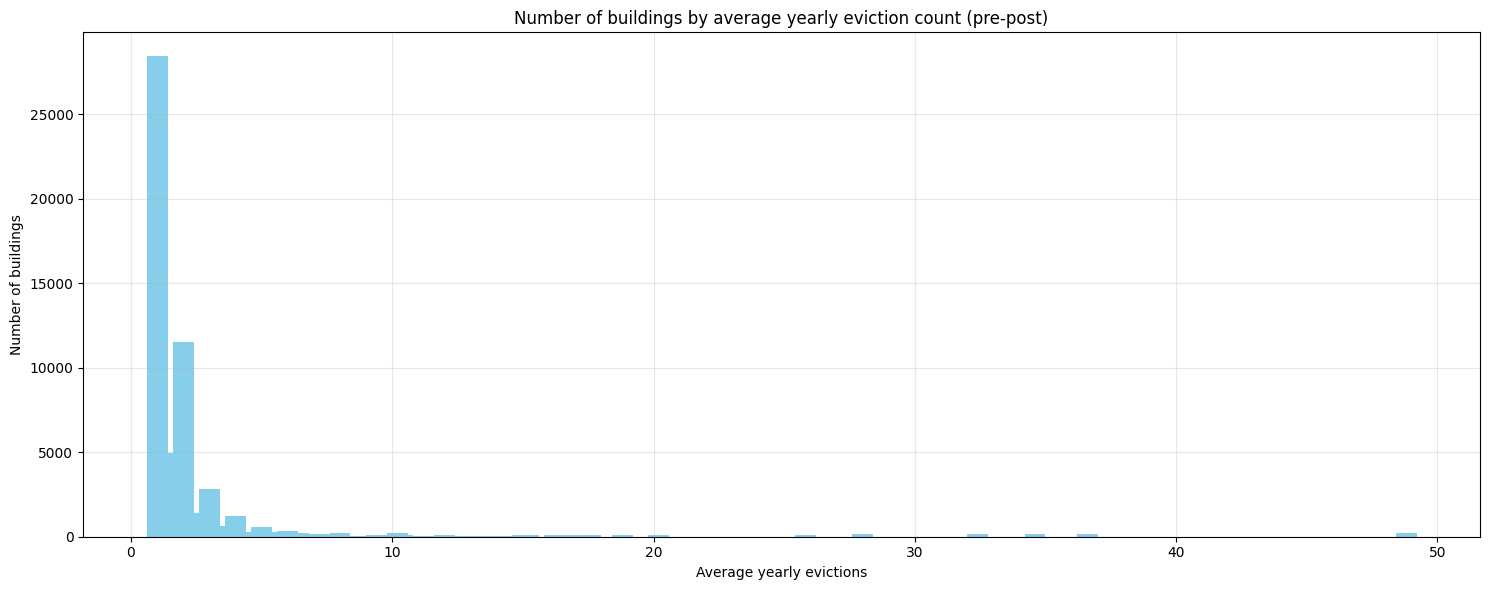

In [153]:
eviction_counts = evictions_pre_post_covid['average_year_eviction_count'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
bars = plt.bar(eviction_counts.index, eviction_counts.values, color='skyblue')

plt.title('Number of buildings by average yearly eviction count (pre-post)', fontsize=12)
plt.xlabel('Average yearly evictions')
plt.ylabel('Number of buildings')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# create stats
total_buildings = eviction_counts.sum()
buildings_one_eviction = eviction_counts.get(1.0, 0)
percentage_one_eviction = (buildings_one_eviction / total_buildings) * 100

In [154]:
print("Summary pre-post:")
print(f"Total buildings: {total_buildings:,}")
print(f"Most common eviction count: {eviction_counts.index[eviction_counts.argmax()]:.2f} ({eviction_counts.max():,} buildings)")
print(f"Buildings with exactly one eviction: {buildings_one_eviction:,} ({percentage_one_eviction:.1f}%)")

Summary pre-post:
Total buildings: 74,082
Most common eviction count: 1.00 (28,435 buildings)
Buildings with exactly one eviction: 28,435 (38.4%)


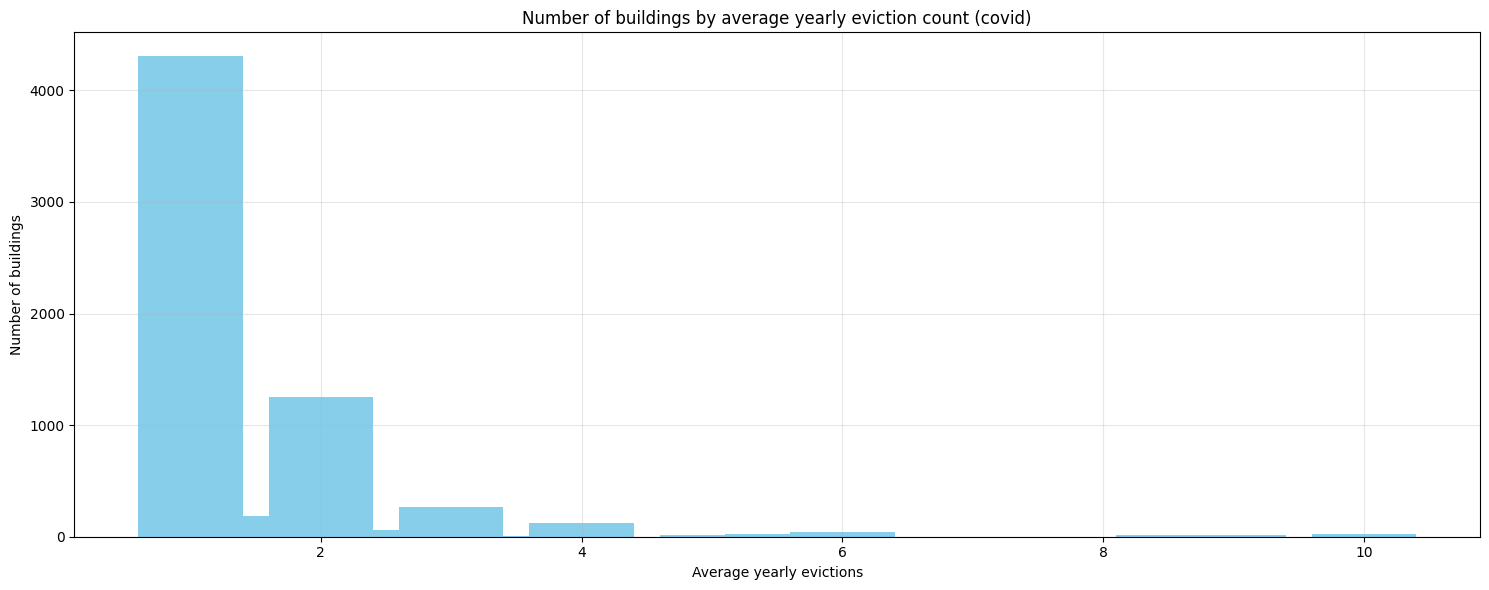

In [155]:
eviction_counts = evictions_covid['average_year_eviction_count'].value_counts().sort_index()

plt.figure(figsize=(15, 6))
bars = plt.bar(eviction_counts.index, eviction_counts.values, color='skyblue')

plt.title('Number of buildings by average yearly eviction count (covid)', fontsize=12)
plt.xlabel('Average yearly evictions')
plt.ylabel('Number of buildings')

plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# stats calculations
total_buildings = eviction_counts.sum()
buildings_one_eviction = eviction_counts.get(1.0, 0)
percentage_one_eviction = (buildings_one_eviction / total_buildings) * 100

In [156]:
print("Summary:")
print(f"Total buildings covid: {total_buildings:,}")
print(f"Most common eviction count: {eviction_counts.index[eviction_counts.argmax()]:.2f} ({eviction_counts.max():,} buildings)")
print(f"Buildings with exactly one eviction: {buildings_one_eviction:,} ({percentage_one_eviction:.1f}%)")

Summary:
Total buildings covid: 6,338
Most common eviction count: 1.00 (4,305 buildings)
Buildings with exactly one eviction: 4,305 (67.9%)


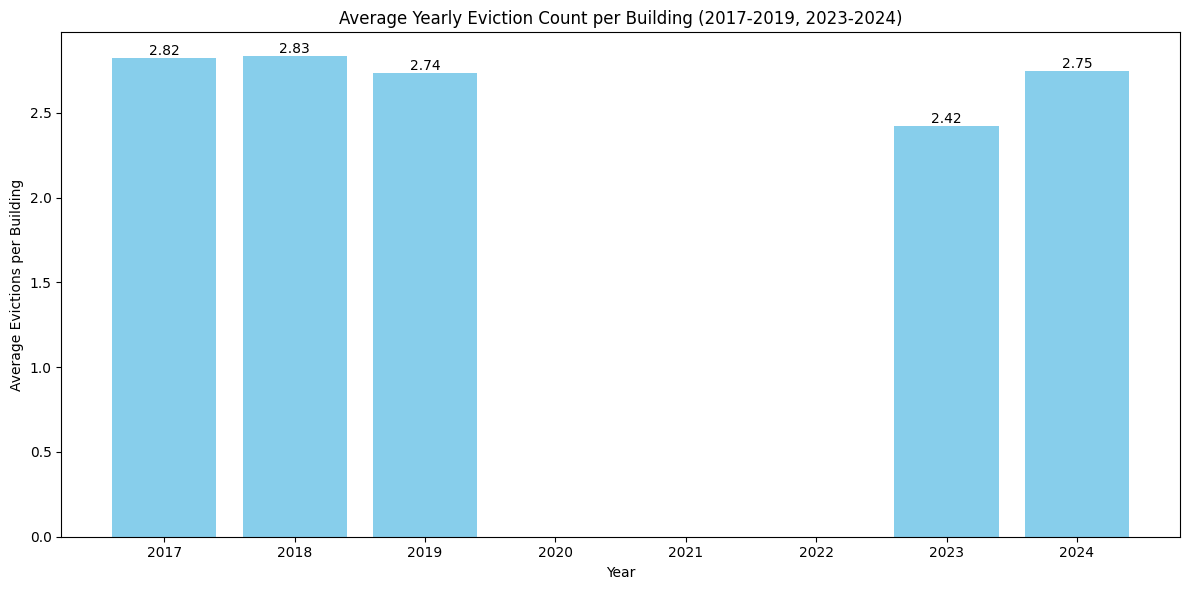

In [157]:
yearly_means = evictions_pre_post_covid.groupby('year')['average_year_eviction_count'].mean()

plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_means.index, yearly_means.values, color='skyblue')

plt.title('Average Yearly Eviction Count per Building (2017-2019, 2023-2024)', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Average Evictions per Building')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [159]:
print("Summary Statistics (pre-post):")
print(f"Overall mean: {yearly_means.mean():.2f}")
print(f"Maximum average ({yearly_means.idxmax()}): {yearly_means.max():.2f}")
print(f"Minimum average ({yearly_means.idxmin()}): {yearly_means.min():.2f}")
print("\nYearly averages per year:")
for year, avg in yearly_means.items():
    print(f"{year}: {avg:.2f}")

Summary Statistics (pre-post):
Overall mean: 2.71
Maximum average (2018): 2.83
Minimum average (2023): 2.42

Yearly averages per year:
2017: 2.82
2018: 2.83
2019: 2.74
2023: 2.42
2024: 2.75


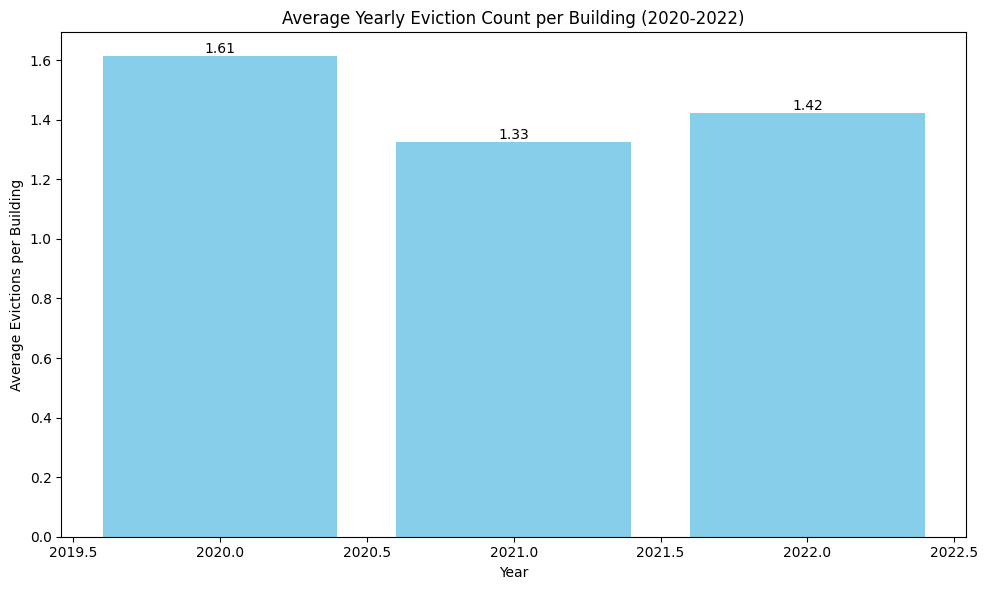

In [107]:
yearly_means = evictions_covid.groupby('year')['average_year_eviction_count'].mean()

plt.figure(figsize=(10, 6))
bars = plt.bar(yearly_means.index, yearly_means.values, color='skyblue')

plt.title('Average Yearly Eviction Count per Building (2020-2022)', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Average Evictions per Building')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [160]:
print("Summary Statistics covid:")
print(f"Overall mean: {yearly_means.mean():.2f}")
print(f"Maximum average ({yearly_means.idxmax()}): {yearly_means.max():.2f}")
print(f"Minimum average ({yearly_means.idxmin()}): {yearly_means.min():.2f}")

Summary Statistics covid:
Overall mean: 2.71
Maximum average (2018): 2.83
Minimum average (2023): 2.42


# Part 3 Visualize the GeoDataFrame -- Plotly and Folium

## Part 3.1 Plotly first:

### Part 3.1.1 pre-post covid


In [161]:
# scatter map showing eviction counts by BBL
# a very basic and high-level visualization of each building's annual eviction during the year pre and post covid
# the outlines are clear. They are the lighter and orange ones.
fig = px.scatter_geo(evictions_pre_post_covid,
                     lat='latitude', lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [162]:
# not let the ones < 5 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 5]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC (5+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [163]:
# not let the ones < 10 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 10]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC (10+ Evictions) pre-post")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

### Part 3.1.2 plotly covid

In [165]:
fig = px.scatter_geo(evictions_covid,
                     lat='latitude', lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC covid")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [166]:
# not let the ones < 5 shown
evictions_filtered = evictions_covid[evictions_covid['average_year_eviction_count'] >= 5]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC (5+ Evictions) covid")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [167]:
# not let the ones < 10 shown
evictions_filtered = evictions_covid[evictions_covid['average_year_eviction_count'] >= 10]
fig = px.scatter_geo(evictions_filtered,
                     lat='latitude',
                     lon='longitude',
                     color='average_year_eviction_count',
                     hover_name='bbl',
                     title="Evictions by BBL in NYC (10+ Evictions) covid")

fig.update_geos(scope='usa', fitbounds="locations")
fig.show()

In [118]:
# # in case the graph does not load, it is as shown below
# # it is originally an interactive graph where if you point to a building, you get the bbl id, laititude, longitude, and
# # the annual eviction counts
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='plotly_image.png')

In [119]:
# # save as an interactive HTML file
# pio.write_html(fig, file='evictions_map.html', auto_open=False)

#### Short summaries:  
- During covid, buildings with high evictions were drastically fewer than normal times. And the buildings with high evictions were consistent with the normal times'.[link text](https://)


## Part 3.2 Folium:

### Part 3.2.1 Folium pre-post covid

In [123]:
# use folium heatmap to show the data in a better visualization
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (all buildings with evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']] for index, row in evictions_pre_post_covid.iterrows()]
HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [122]:
# not let the ones < 5 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 5]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# html
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (5+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [124]:
# not let the ones < 10 shown
evictions_filtered = evictions_pre_post_covid[evictions_pre_post_covid['average_year_eviction_count'] >= 10]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# HTML
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap pre post covid (10+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))

heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [125]:
# # in case it does not load, it is as shown below
# from google.colab import files
# from IPython.display import Image
# uploaded = files.upload()
# Image(filename='heat_map.png')

### Part 3.2.2 Folium Covid

In [128]:
# use folium heatmap to show the data in a better visualization
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap Covid (all buildings with evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']] for index, row in evictions_covid.iterrows()]
HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [129]:
# not let the ones < 5 shown
evictions_filtered = evictions_covid[evictions_covid['average_year_eviction_count'] >= 5]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# html
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap Covid (5+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))
heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

In [131]:
# not let the ones < 10 shown
evictions_filtered = evictions_covid[evictions_covid['average_year_eviction_count'] >= 10]

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=11)
# HTML
title_html = '''
             <div style="position: fixed;
                         top: 10px;
                         left: 50%;
                         transform: translateX(-50%);
                         z-index: 1000;
                         background-color: white;
                         padding: 10px;
                         border-radius: 5px;
                         border: 2px solid grey;
                         font-size: 16px;
                         font-weight: bold;">
                 NYC Evictions Heatmap covid (10+ Evictions per building)
             </div>
             '''
nyc_map.get_root().html.add_child(folium.Element(title_html))

heat_data = [[row['latitude'], row['longitude'], row['average_year_eviction_count']]
             for index, row in evictions_filtered.iterrows()]

HeatMap(heat_data, radius=10).add_to(nyc_map)

nyc_map

#### Short summaries:
- Based on the analysis of NYC eviction data in two periods, there's a clear distinction between eviction patterns during and outside of the covid period. In the pre/post covid years (2017-2019, 2023-2024), evictions had a higher rate, with more buildings affected and a higher average number of evictions per building. During the Covid period (2020-2022), there was a significant decrease in eviction activity, likely due to eviction moratoriums and other protective measures implemented during the pandemic, and a decrease in rents with many residents fleeing NYC. This is interesting, as it is consistent with the phenomenon that lower rents/less competitive environment overall actually suppress evictions.

- In both periods, the majority of buildings experienced just one eviction per year, suggesting that most landlords use eviction as an occasional rather than frequent measure. However, there were some properties with notably higher eviction counts, particularly in the normal years. These concentrated areas also tend to be the regular buildings and neighborhoods who show persistent behaviors over the years.

- Foliums shows clear geo relationships with the NYC background. Plotly shows the drastic change with less background distractions.

# Part 3 Buildings with high evictions in 2 periods

In [ ]:
# evictions_cleaned.columns
## didn't change

In [134]:
# the number of unique building codes is 34032 in this dataset
len(evictions_pre_post_covid.bbl.unique()), \
len(evictions_covid.bbl.unique())

(32856, 4978)

### Part 3.1 Buildings with the most evictions in pre-post covid times

In [135]:
# sort by eviction_count and extract the top 10 records based on the average_year_eviction_count column
top_bbls_pre_post = evictions_pre_post_covid[['bbl', 'average_year_eviction_count']].groupby('bbl').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bbls_pre_post.shape

(32856, 1)

In [137]:
top_bbls_pre_post.head(20)

average_year_eviction_count
bbl                                      
2.028820e+09                    48.800000
2.051410e+09                    36.600000
4.124950e+09                    34.600000
2.039448e+09                    32.400000
4.159260e+09                    28.000000
2.039438e+09                    25.800000
4.156100e+09                    20.200000
3.042719e+09                    18.800000
3.036280e+09                    17.600000
2.045060e+09                    16.800000
2.049050e+09                    16.333333
2.045060e+09                    16.200000
2.026188e+09                    15.200000
2.039388e+09                    15.000000
1.003560e+09                    14.333333
3.049810e+09                    13.800000
3.049670e+09                    13.200000
3.049810e+09                    13.000000
4.160020e+09                    12.800000
1.017370e+09                    12.400000

In [139]:
bbls_over_10_evictions = top_bbls_pre_post[top_bbls_pre_post['average_year_eviction_count'] > 10]
bbls_over_10_evictions.shape
# 18 buildings have eviction counts larger than 10 per year on average

(33, 1)

In [140]:
bbls_over_10_evictions

average_year_eviction_count
bbl                                      
2.028820e+09                    48.800000
2.051410e+09                    36.600000
4.124950e+09                    34.600000
2.039448e+09                    32.400000
4.159260e+09                    28.000000
2.039438e+09                    25.800000
4.156100e+09                    20.200000
3.042719e+09                    18.800000
3.036280e+09                    17.600000
2.045060e+09                    16.800000
2.049050e+09                    16.333333
2.045060e+09                    16.200000
2.026188e+09                    15.200000
2.039388e+09                    15.000000
1.003560e+09                    14.333333
3.049810e+09                    13.800000
3.049670e+09                    13.200000
3.049810e+09                    13.000000
4.160020e+09                    12.800000
1.017370e+09                    12.400000
2.039378e+09                    12.000000
3.049640e+09                    12.000000
4.160010e+09                    11.800000
5.012720e+09                    11.600000
2.026100e+09                    11.250000
2.051350e+09                    11.200000
3.044520e+09                    10.600000
5.029220e+09                    10.400000
1.017600e+09                    10.400000
5.029220e+09                    10.200000
2.027428e+09                    10.200000
2.022958e+09                    10.200000
1.010908e+09                    10.200000

### Part 3.2 Buildings with the most evictions in covid times

In [143]:
# sort by eviction_count and extract the top 10 records based on the average_year_eviction_count column
top_bbls_covid = evictions_covid[['bbl', 'average_year_eviction_count']].groupby('bbl').mean().sort_values(by='average_year_eviction_count', ascending=False)
top_bbls_covid.shape

(4978, 1)

In [144]:
top_bbls_covid.head(20)

average_year_eviction_count
bbl                                      
2.028820e+09                         10.0
4.124950e+09                          9.0
2.051410e+09                          8.5
2.024160e+09                          6.0
5.012640e+09                          6.0
3.012730e+09                          6.0
5.000500e+09                          6.0
5.001980e+09                          6.0
3.014720e+09                          6.0
5.039830e+09                          6.0
2.039438e+09                          5.5
3.042719e+09                          5.5
3.070030e+09                          5.0
4.159260e+09                          5.0
2.051070e+09                          5.0
3.057158e+09                          4.0
3.030520e+09                          4.0
2.024350e+09                          4.0
1.003150e+09                          4.0
5.012720e+09                          4.0

In [146]:
bbls_over_5_evictions = top_bbls_covid[top_bbls_covid['average_year_eviction_count'] > 5]
bbls_over_5_evictions.shape
# no buildings have more than 10 evictions during the years affected by covid

(12, 1)

In [147]:
bbls_over_5_evictions

average_year_eviction_count
bbl                                      
2.028820e+09                         10.0
4.124950e+09                          9.0
2.051410e+09                          8.5
2.024160e+09                          6.0
5.012640e+09                          6.0
3.012730e+09                          6.0
5.000500e+09                          6.0
5.001980e+09                          6.0
3.014720e+09                          6.0
5.039830e+09                          6.0
2.039438e+09                          5.5
3.042719e+09                          5.5

### TODO:
### Some potential research questions/hypothesis include:
    - look into each of these buildings and check who the landlords are. (with the merge of BBL)
    - are they individual landlord or corporate landlords?
    - do they habitually exbihit such behavior?
    - is there a reason for the evictions besides the tenants' behavior?
    - is this related to building policy changes?
    - is this related to city-wide/neighborhood-wide changes?
### Another dataset we will be using: BBL.csv
    - pull the info of the buildings from bbl
    - since there are only 18 of them, we can have a closer look at them and then get a writeup of the landlords' background.

#### The rest of the analysis will be broken down into different notebooks

In [148]:
# save cleaned evictions data to my drive
evictions_pre_post_covid.to_csv('/content/drive/My Drive/X999/evictions_pre_post_covid.csv', index=False)

In [149]:
# save cleaned evictions data to my drive
evictions_covid.to_csv('/content/drive/My Drive/X999/evictions_covid.csv', index=False)